<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S07_Intro_ML/Demo_tweet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# IMPORTS & SETUP
# ==========================================
# Import pandas for data manipulation and analysis
import pandas as pd
# Import numpy for numerical operations, especially with arrays
import numpy as np
# Import matplotlib.pyplot for basic plotting functionalities
import matplotlib.pyplot as plt
# Import seaborn for advanced data visualization
import seaborn as sns

# Scikit-Learn (Traditional ML) - A library for machine learning in Python
from sklearn.model_selection import train_test_split # Used for splitting data into training and testing sets
from sklearn.feature_extraction.text import TfidfVectorizer # Used for converting text data into numerical TF-IDF features
from sklearn.tree import DecisionTreeClassifier # Used for building a Decision Tree classification model
from sklearn.linear_model import LogisticRegression  # Baseline Linear Model for classification
from sklearn.metrics import classification_report # Used for evaluating classification model performance
from sklearn.preprocessing import LabelEncoder # Used for encoding categorical labels into numerical format

# LightGBM (Gradient Boosting) - A high-performance gradient boosting framework
import lightgbm as lgb # Used for building a LightGBM classification model

# Deep Learning (Keras/TensorFlow) - Libraries for building and training neural networks
import tensorflow as tf # Core TensorFlow library
from tensorflow.keras.models import Sequential # Used for building sequential Keras models
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D # Various Keras layers for neural networks
from tensorflow.keras.preprocessing.text import Tokenizer # Used for converting text into sequences of integers
from tensorflow.keras.preprocessing.sequence import pad_sequences # Used for padding sequences to a uniform length

# **Block 1:** data input

In [2]:

# ==========================================
# 1. LOAD DATA (Airline Tweets)
# ==========================================
print("Downloading dataset...")
# URL of the dataset to be downloaded
url = "https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/S07_Intro_ML/data/tweets_data_filtered.csv"
# Read the CSV file from the URL into a pandas DataFrame
df = pd.read_csv(url)
# Display the entire DataFrame (or its head if it's very large)
df

,text,category
0,plus you've added commercials to the experienc...,Satisfied
1,"yes, nearly every time I fly VX this “ear worm...",Satisfied
2,"Well, I didn't…but NOW I DO! :-D",Satisfied
3,"it was amazing, and arrived an hour early. You...",Satisfied
4,I &lt;3 pretty graphics. so much better than m...,Satisfied
...,...,...
5594,Thank you. “: Customer Relations will review ...,Satisfied
5595,Thanks! He is.,Satisfied
5596,"my flight was cancelled, leaving tomorrow morn...",Flight Issue
5597,right on cue with the delays👌,Flight Issue


# **Block 2:** Feature preparation & Feature engineering

## Term Frequency - Inverse Document Frequency (TF-IDF) features for text data

We use the following line of code to process the text:
`TfidfVectorizer(stop_words='english', max_features=1000)`

Here is what it does:
* **`TfidfVectorizer`:** This tool converts words into numbers (values). Instead of just counting words, it assigns a "Uniqueness Score."
    * **Common words** get low scores.
    * **Rare words** get high scores.
* **`stop_words='english'`:** This tells the computer to ignore common grammatical fillers that carry no meaning, such as *"the"*, *"is"*, *"and"*, *"of"*.
* **`max_features=1000`:** This forces the model to focus only on the **top 1,000 most important words** in the entire dataset. It ignores rare typos or irrelevant words.

---

## How is the TF-IDF score Calculated?
The TF-IDF score is the product of two numbers: **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**.

$$\text{TF-IDF} = \text{TF} \times \text{IDF}$$

### Step 1: Term Frequency (TF)
*"How often does the word appear in THIS specific text?"*
If a customer writes "late" 5 times, it is very important to that specific email.

$$\text{TF} = \frac{\text{Count of word in document}}{\text{Total words in document}}$$

### Step 2: Inverse Document Frequency (IDF)
*"How rare is this word across ALL data points/rows (tweets)?"* This is the penalty for generic words.
* If a word appears in **every** tweet, the IDF is **low** (near 0).
* If a word appears in **only one** tweet (e.g., "shattered"), the IDF is **high**.

$$\text{IDF} = \log \left( \frac{1+\text{Total Number of Documents}}{1+\text{Number of Documents containing the word}} \right)+1$$

### A Simple Example
Based on the following 3 short tweets:
1.  **Doc A:** "Delivery late"
2.  **Doc B:** "Delivery fast"
3.  **Doc C:** "Package lost"

**Why does "Late" get a higher score than "Delivery"?**

| Word | Found In... | Logic | Score |
| :--- | :--- | :--- | :--- |
| **"Delivery"** | Doc A & Doc B | It is **common** (found in 2/3 docs). The model thinks it is less important. | **0.56** |
| **"Late"** | Doc A only | It is **unique** (found in 1/3 docs). The model highlights it as a key signal. | **0.65** |

**Note:**
*  "Delivery (Tweet A)": $\text{TF} = 0.5, \text{IDF} = \log\left( \frac{1+3}{1+2} \right)+1=1.12, \text{TF-IDF} = 0.5\times1.12 = 0.56$
*  "Late (Tweet A)": $\text{TF} = 0.5, \text{IDF} = \log\left( \frac{1+3}{1+1} \right)+1=1.30, \text{TF-IDF} = 0.5\times1.30 = 0.65$


**Result:** The model ignores the generic topic ("Delivery") and focuses purely on the problem ("Late").

In [3]:
from google.colab import files # Import files module for Google Colab to download files

# ==========================================
# PREPROCESSING & SPLIT
# ==========================================
# Initialize LabelEncoder to convert categorical labels to numerical ones
le = LabelEncoder()
# Apply LabelEncoder to the 'category' column to create numerical labels
df['label'] = le.fit_transform(df['category'])
# Determine the number of unique classes after encoding
num_classes = len(le.classes_)

# Split the dataset into training and testing sets
# X_train_text, X_test_text: text data for training and testing
# y_train, y_test: corresponding numerical labels for training and testing
# test_size=0.2: 20% of data for testing, 80% for training
# random_state=42: Ensures reproducibility of the split
# stratify=df['label']: Ensures that the proportion of classes is the same in train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Print the number of samples in the training and testing sets
print(f"\nTraining on {len(X_train_text)} samples | Testing on {len(X_test_text)} samples")

# ==========================================
# 3. FEATURE ENGINEERING (TF-IDF)
# ==========================================
# Shared by Tree, Logistic Regression, and LightGBM models
# Initialize TfidfVectorizer:
# stop_words='english': Removes common English stop words (e.g., 'the', 'is', 'a')
# max_features=1000: Considers only the top 1000 most frequent words/terms
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit the TF-IDF vectorizer on the training text data and transform it into a TF-IDF matrix
# .toarray() converts the sparse matrix output to a dense NumPy array
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()

# Transform the testing text data using the *fitted* TF-IDF vectorizer
X_test_tfidf = tfidf.transform(X_test_text).toarray()


Training on 4479 samples | Testing on 1120 samples


In [4]:
# NOTE: this part of code is optional. It is to show and export the TD-IDF input features
# Create DataFrame for first 100 rows of the TF-IDF training data to display
# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
# Create a pandas DataFrame from the first 50 rows of X_train_tfidf, using feature_names as columns
tfidf_df = pd.DataFrame(X_train_tfidf[:50], columns=feature_names)
# Define the filename for saving the TF-IDF sample as a CSV
csv_filename = 'tfidf_sample.csv'
# Save the sample TF-IDF DataFrame to a CSV file without the index
tfidf_df.to_csv(csv_filename, index=False)
# Download the generated CSV file to the local machine (specific to Google Colab)
files.download(csv_filename)
# Display the head of the TF-IDF DataFrame
tfidf_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,000,10,100,1000,11,12,13,14,15,16,...,ya,yall,yeah,year,years,yep,yes,yesterday,yr,yyz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.451718,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Blocks 3 & 4:** Machine Learning Models - Training and Validation

## Model A: Decision Tree

In [5]:
# --- Model A: Decision Tree ---
print("\n--- Training Model A: Decision Tree ---")
# Initialize Decision Tree Classifier with a maximum depth of 10 and a fixed random state for reproducibility
tree_model = DecisionTreeClassifier(max_depth=10, random_state=42)
# Train the Decision Tree model using the TF-IDF transformed training data and labels
tree_model.fit(X_train_tfidf, y_train)
# Make predictions on the TF-IDF transformed test data
tree_preds = tree_model.predict(X_test_tfidf)
# Print the classification report, showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, tree_preds, target_names=le.classes_))


--- Training Model A: Decision Tree ---
               precision    recall  f1-score   support

 Flight Issue       0.85      0.61      0.71       502
Luggage Issue       0.81      0.69      0.74       145
    Satisfied       0.66      0.89      0.76       473

     accuracy                           0.74      1120
    macro avg       0.77      0.73      0.74      1120
 weighted avg       0.77      0.74      0.74      1120



## Model B: Logistic Regression

In [6]:
# --- Model B: Logistic Regression ---
print("\n--- Training Model B: Logistic Regression ---")
# Excellent baseline for text. Linear boundary is often enough for "keywords".
# Initialize Logistic Regression model with a maximum of 1000 iterations and a fixed random state
lr_model = LogisticRegression(max_iter=1000, random_state=42)
# Train the Logistic Regression model using the TF-IDF transformed training data and labels
lr_model.fit(X_train_tfidf, y_train)
# Make predictions on the TF-IDF transformed test data
lr_preds = lr_model.predict(X_test_tfidf)
# Print the classification report
print(classification_report(y_test, lr_preds, target_names=le.classes_))


--- Training Model B: Logistic Regression ---
               precision    recall  f1-score   support

 Flight Issue       0.87      0.91      0.89       502
Luggage Issue       0.89      0.74      0.81       145
    Satisfied       0.89      0.89      0.89       473

     accuracy                           0.88      1120
    macro avg       0.88      0.85      0.86      1120
 weighted avg       0.88      0.88      0.88      1120



## Model C: LightGBM

In [7]:
# --- Model C: LightGBM ---
print("\n--- Training Model C: LightGBM ---")
# Gradient boosting: Often the strongest performer on tabular/sparse data.
# We use the Scikit-Learn API wrapper of LightGBM for simplicity
# Initialize LightGBM Classifier with a fixed random state and suppress verbose output
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
# Train the LightGBM model using the TF-IDF transformed training data and labels
lgb_model.fit(X_train_tfidf, y_train)
# Make predictions on the TF-IDF transformed test data
lgb_preds = lgb_model.predict(X_test_tfidf)
# Print the classification report
print(classification_report(y_test, lgb_preds, target_names=le.classes_))




--- Training Model C: LightGBM ---
               precision    recall  f1-score   support

 Flight Issue       0.87      0.86      0.87       502
Luggage Issue       0.80      0.81      0.80       145
    Satisfied       0.87      0.88      0.88       473

     accuracy                           0.86      1120
    macro avg       0.85      0.85      0.85      1120
 weighted avg       0.86      0.86      0.86      1120



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## (Supplement) Model D: Deep Learning with word embedding layer
(NOTE: the detail of the model is not covered in this class as it requires deeper understanding of the structure of the deep learning model layers)

### NOTE: What is an "Embedding" Layer?

In simple terms, the **Embedding Layer** acts as a **Smart Translator**. When we tokenize text, we turn words into integers:
* "Late" $\rightarrow$ 45
* "Delayed" $\rightarrow$ 982
* "Happy" $\rightarrow$ 12

To a computer, **45** and **982** look completely unrelated. The math assumes "Delayed" (982) is much "bigger" than "Late" (45), which is false as they mean the same thing.


The Embedding layer gives every word a specific location in a multi-dimensional map (a vector of numbers). Instead of just `45`, the word **"Late"** becomes a list of coordinates, like: `[0.2, -0.5, 0.9, ...]`

**Embedding later in deep learning:**
During training, the model moves words with similar meanings closer together on this map.
* **"Late"** and **"Delayed"** will end up with very similar coordinates.
* **"Late"** and **"Happy"** will end up far apart.

For example, after training, when plotting words on a 2D map (two coordinates):

| Word | Dimension A (Positivity) | Dimension B (Urgency) |
| :--- | :--- | :--- |
| **"Late"** | -0.9 (Bad) | 0.9 (High) |
| **"Delayed"** | -0.8 (Bad) | 0.9 (High) |
| **"Good"** | 0.9 (Good) | 0.1 (Low) |

You can see how "Late" and "Delayed" have almost the same numbers. This helps the Deep Learning model understand that they are synonyms. This transformation is directly integrated into the deep learning model during training (i.e., feature engineering is **automatically** performed rather than pre-calculated like TD-IDF).

In [8]:
# --- Model D: Deep Learning (Embeddings) ---
print("\n--- Training Model D: Deep Learning ---")
# Preprocessing unique to DL
# Define vocabulary size for the Tokenizer
vocab_size = 2000
# Define the dimension of the embedding vectors
embedding_dim = 16
# Define the maximum length of input sequences
max_length = 30
# Define truncation type ('post' means truncate from the end)
trunc_type = 'post'

# Initialize Tokenizer with the specified vocabulary size and an out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
# Fit the tokenizer on the training text data to build the word index
tokenizer.fit_on_texts(X_train_text)

# Convert training text into sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train_text)
# Convert testing text into sequences of integers
test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Pad training sequences to a uniform length (max_length)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
# Pad testing sequences to a uniform length (max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

# Build the Deep Learning model (Sequential Keras model)
dl_model = Sequential([
    # Embedding layer: Converts integer-encoded words into dense vectors of fixed size
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # GlobalAveragePooling1D layer: Averages the embedding vectors across the sequence dimension
    GlobalAveragePooling1D(),
    # Dense layer with 24 units and ReLU activation function
    Dense(24, activation='relu'),
    # Dropout layer: Randomly sets a fraction of input units to 0 at each update during training to prevent overfitting
    Dropout(0.5),
    # Output Dense layer with 'num_classes' units and 'softmax' activation for multi-class classification probabilities
    Dense(num_classes, activation='softmax')
])

# Compile the model:
# loss='sparse_categorical_crossentropy': Suitable for integer-encoded labels
# optimizer='adam': An adaptive learning rate optimization algorithm
# metrics=['accuracy']: Metric to monitor during training and evaluation
dl_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the Deep Learning model:
# epochs=20: Number of times to iterate over the entire training dataset
# validation_data=(test_padded, y_test): Data on which to evaluate the loss and any model metrics at the end of each epoch
# verbose=0: Suppress training output
dl_model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), verbose=0)

# Evaluate the trained Deep Learning model on the test data
loss, accuracy = dl_model.evaluate(test_padded, y_test, verbose=0)
# Print the accuracy of the Deep Learning model
print(f"Deep Learning Accuracy: {accuracy*100:.2f}%")
# Make predictions with the Deep Learning model on the test data
# np.argmax converts the probability distribution output to class labels
dl_preds = np.argmax(dl_model.predict(test_padded, verbose=0), axis=1)
# Print the classification report for the Deep Learning model
print(classification_report(y_test, dl_preds, target_names=le.classes_))


--- Training Model D: Deep Learning ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Deep Learning Accuracy: 87.14%
               precision    recall  f1-score   support

 Flight Issue       0.85      0.93      0.89       502
Luggage Issue       0.86      0.70      0.77       145
    Satisfied       0.90      0.86      0.88       473

     accuracy                           0.87      1120
    macro avg       0.87      0.83      0.85      1120
 weighted avg       0.87      0.87      0.87      1120



Run the code below if you want to display the illustration of the neural network model above

Generating Model Architecture Diagram...


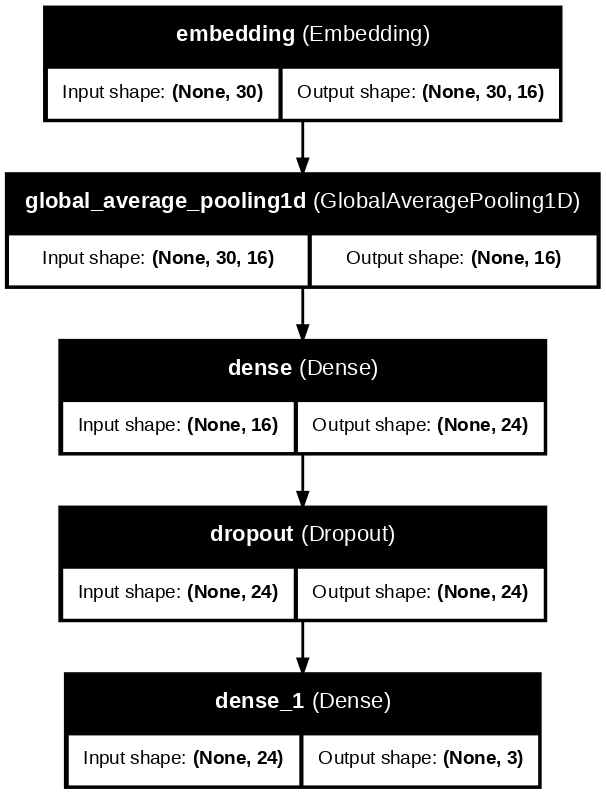

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# The dl_model was already built and trained in the previous cell,
# so explicitly calling .build() here is not necessary. We can remove this line.
# dl_model.build(input_shape=(None, max_length))

# ============================================
# GENERATE DIAGRAM
# ============================================
print("Generating Model Architecture Diagram...")

plot_path = 'model_architecture.png'

# Plot the Deep Learning model (dl_model)
plot_model(dl_model,
           to_file=plot_path,
           show_shapes=True,      # Shows inputs/outputs (e.g., 30 words -> 16 numbers)
           show_layer_names=True, # Shows the custom names we defined above
           rankdir='TB',          # TB = Top to Bottom flow
           dpi=100                # Image resolution
)

# Display the image inline
display(Image(plot_path))

# **Prediction:** show live prediction based on the text input
(this widget is vibe-coded created using Gemini 😏)

In [10]:
# Interactive Python widget
import ipywidgets as widgets
from IPython.display import display, clear_output

# ==========================================
# INTERACTIVE WIDGET
# ==========================================
print("\n" + "="*40)
print("INTERACTIVE CLASSIFIER (With Confidence Scores)")
print("="*40)

text_input = widgets.Text(
    value='',
    placeholder='Type simulated review...',
    description='Log:',
    disabled=False
)

out = widgets.Output()

def get_prediction_and_confidence(model, vector):
    # predict_proba returns array like [[0.1, 0.8, 0.1]]
    probs = model.predict_proba(vector)[0]
    idx = np.argmax(probs)
    label = le.classes_[idx]
    confidence = np.max(probs) * 100
    return label, confidence

def on_text_submit(change):
    with out:
        clear_output()
        input_text = change.new
        if not input_text: return

        print(f"Analysis for: '{input_text}'\n" + "-"*30)

        # Preprocessing
        vec = tfidf.transform([input_text]).toarray()

        # 1. Tree
        # Trees can output probabilities (fraction of samples in the leaf)
        t_lbl, t_conf = get_prediction_and_confidence(tree_model, vec)
        print(f"🌲 Decision Tree:       [{t_lbl}] (Conf: {t_conf:.1f}%)")

        # 2. Logistic Regression
        lr_lbl, lr_conf = get_prediction_and_confidence(lr_model, vec)
        print(f"📈 Logistic Regression: [{lr_lbl}] (Conf: {lr_conf:.1f}%)")

        # 3. LightGBM
        gb_lbl, gb_conf = get_prediction_and_confidence(lgb_model, vec)
        print(f"🚀 LightGBM:            [{gb_lbl}] (Conf: {gb_conf:.1f}%)")

        # 4. Deep Learning
        seq = tokenizer.texts_to_sequences([input_text])
        padded = pad_sequences(seq, maxlen=max_length)
        dl_probs = dl_model.predict(padded, verbose=0)[0]
        dl_idx = np.argmax(dl_probs)
        dl_conf = np.max(dl_probs) * 100
        print(f"🧠 Deep Learning:       [{le.classes_[dl_idx]}] (Conf: {dl_conf:.1f}%)")

text_input.observe(on_text_submit, names='value')
display(text_input)
display(out)


INTERACTIVE CLASSIFIER (With Confidence Scores)


Text(value='', description='Log:', placeholder='Type simulated review...')

Output()